In [1]:
"""
DNN Experiments Serrano/AUDSOME Phase 1
Anomaly Only
Gabriel Iuhasz
"""
import os
# limit GPU allocation
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" #issue #152
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import numpy as np
np.random.seed(42)
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import balanced_accuracy_score, make_scorer, classification_report, accuracy_score, jaccard_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced


# from sklearn.externals import joblib
from joblib import dump, load
import json
import matplotlib.pyplot as plt
import seaborn as sns
from evolutionary_search import EvolutionaryAlgorithmSearchCV
from subprocess import check_output
%matplotlib inline

In [2]:
def custom_scoring_reporting(y_pred,
                             y,
                             definitions,
                             prefix):
    """
    Custom function for handling scoring and reporting
    :param y_pred: model predictions
    :param y: ground truth
    :param definitions: variable class definitions (factorize)
    :param prefix: prefix to saved files and images
    :return: 0
    """
    print("Accuracy score is: {}".format(accuracy_score(y, y_pred)))
    print("Ballanced accuracy score is: {}".format(balanced_accuracy_score(y, y_pred)))
    print("Jaccard score (micro): {}".format(jaccard_score(y, y_pred, average='micro')))
    print("Jaccard score (macro): {}".format(jaccard_score(y, y_pred, average='macro')))
    print("Jaccard score (weighted): {}".format(jaccard_score(y, y_pred, average='weighted')))


    print("Full classification report")
    print(classification_report(y, y_pred, digits=4, target_names=definitions))
    report = classification_report(y, y_pred, digits=4, output_dict=True)
    df_classification_report = pd.DataFrame(report).transpose()
    classification_rep_name = "{}_classification_rep_best.csv".format(prefix)
    df_classification_report.to_csv(os.path.join(model_dir,classification_rep_name), index=False)


    print("Imbalanced Classification report")
    print(classification_report_imbalanced(y, y_pred, digits=4, target_names=definitions))
    imb_report = classification_report_imbalanced(y, y_pred, digits=4, target_names=definitions, output_dict=True)
    df_imb_classification_report = pd.DataFrame(imb_report).transpose()
    classification_imb_rep_name = "{}_imb_classification_rep_best.csv".format(prefix)
    df_imb_classification_report.to_csv(os.path.join(model_dir,classification_imb_rep_name), index=False)



Common preprocessing for all experiments

In [3]:
print("Checking files in data location ...")
train_dir = '/Users/Gabriel/Dropbox/Research/ASPIDE/Datasets/ECI Chaos/Distributed Phase 1/finalized/single_node/training'
# train_dir = '/home/gabriel/Research/Aspide/workspace/data_phase'
# train_dir = '/home/gabriel/research/dipet/serrano/data'
print(check_output(["ls", train_dir]).decode("utf8"))

Checking files in data location ...
data
df_anomaly.csv
df_audsome.csv
df_clean_ausdome_single.csv
df_clean_single.csv
models
processed



In [4]:
print("Setting paths and datasets")
# Checking if directory exists for data, modells and processed

data_dir = os.path.join(train_dir,'data')
model_dir = os.path.join(train_dir,'models')
processed_dir = os.path.join(train_dir,'processed')
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
# if not os.path.exists(processed_dir):
#     os.makedirs(processed_dir)

Setting paths and datasets


In [5]:
df_anomaly = pd.read_csv(os.path.join(train_dir,"df_anomaly.csv"))
df_audsome = pd.read_csv(os.path.join(train_dir,"df_audsome.csv"))
df_clean = pd.read_csv(os.path.join(train_dir,"df_clean_single.csv"))
df_clean_audsome = pd.read_csv(os.path.join(train_dir,"df_clean_ausdome_single.csv"))

# Set index as time
df_anomaly.set_index('time', inplace=True)
df_audsome.set_index('time', inplace=True)
df_clean.set_index('time', inplace=True)
df_clean_audsome.set_index('time', inplace=True)

In [6]:
print("Dataset chosen ...")
data = df_anomaly

# Nice print
nice_y = data['target']
data.shape

Dataset chosen ...


(5400, 90)

In [7]:
# Uncomment for removing dummy TODO CHECK if adding back dummy
# data.loc[data.target == "dummy", 'target'] = "0"

#Creating the dependent variable class
factor = pd.factorize(data['target'])
data.target = factor[0]
definitions = factor[1]
# print(data.target.head())
# print(definitions)

In [8]:
print("Splitting dataset into training and ground truth ...")
X = data.drop('target', axis=1)
y = data['target']

Splitting dataset into training and ground truth ...


Ploting class distribution ..


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


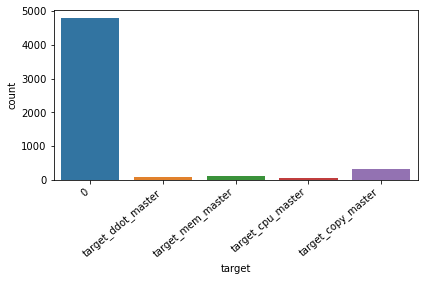

In [9]:
# Plot class distribution
print("Ploting class distribution ..")
pltdist= sns.countplot(nice_y)
pltdist.set_xticklabels(pltdist.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

In [10]:
print("Scaling dataset")
# scaler = StandardScaler()
# scaler = RobustScaler()
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, index=X.index, columns=X.columns) # transform back to df

Scaling dataset


Starting of experiment for DNN only

Parameters:



In [11]:
# Name of experiment
# DNN
prefix = 'Phase1_dnn_evs'
dnn = True # needed for special reporting features
import tensorflow as tf
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Dropout, LSTM, SimpleRNN
from tensorflow.keras.optimizers import Adam, Adagrad, SGD
from tensorflow.keras.utils import plot_model

paramgrid = {
    "optimizer": ["adam", "adagrad", "sgd"],
    "learning_r": [0.01, 0.0001 , 0.003, 0.001],
    "patience" : [4],
    "batch_size": [32, 64, 128, 256],
    "epochs": [300],
    "kernel_init": ['he_uniform', 'he_normal'],
    "layer_1": [0, 50, 100],
    "layer_2": [0,  50, 100],
    "layer_3": [0,  50, 100],
    "layer_0": [0, 200, 100, 50],
    "drop": [0, 0.1, 0.2, 0.3, 0.4],
    "loss": ["categorical_crossentropy"],
    "activation_1": ['relu', 'elu', 'selu'],
    "out_activation":["sigmoid"]
}

y_oh = pd.get_dummies(y, prefix='target')

# Reverse one hot encoding
def reverse_oh(y_oh):
    decode = []
    for r in y_oh:
        # print(r)
        result = np.where(r == 1.)[0]
        # print(result)
        #check if network asigned more than one or non labels
        if len(result) > 1 or len(result) == 0:
            if len(result) > 1:
                result = np.array([result[0]])  # select first class
            elif len(result) == 0:
                result = np.array([0])

        decode.append(result[0])
    return decode


def dnn_aspide(optimizer='adam', #adam, adagrad, sgd
               learning_r = 0.01,
              patience=5,
              batch_size=32,
              epochs=1000,
              kernel_init='he_uniform',
              layer_1 = 20,
              layer_2 = 40,
              layer_3 = 40,
              layer_0 = 100,
              drop = 0.1,
              loss='categorical_crossentropy',
              activation_1 = 'relu', # elu, selu
              out_activation='sigmoid'):
    y_oh = pd.get_dummies(y, prefix='target')
    # print(np.asarray(X).shape[1], len(y_oh.nunique()))
    n_inputs, n_outputs = X.shape[1], len(y_oh.nunique())
    model = Sequential()
    # model.add(Conv1D(filters=32, kernel_size=2,activation=activation_1, input_shape=n_inputs, kernel_initializer=kernel_init))
    model.add(Dense(layer_0, input_dim=n_inputs, kernel_initializer=kernel_init, activation=activation_1))
    if drop:
        model.add(Dropout(drop))
    if layer_1:
        model.add(Dense(layer_1, input_dim=n_inputs, kernel_initializer=kernel_init, activation=activation_1))
        if drop:
            model.add(Dropout(drop))
    if layer_2:
        model.add(Dense(layer_2, input_dim=n_inputs, kernel_initializer=kernel_init, activation=activation_1))
        if drop:
            model.add(Dropout(drop))
    if layer_3:
        model.add(Dense(layer_2, input_dim=n_inputs, kernel_initializer=kernel_init, activation=activation_1))
        if drop:
            model.add(Dropout(drop))
    model.add(Dense(n_outputs, activation=out_activation))
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_r)
    if optimizer == 'adagrad':
        opt = Adagrad(learning_rate=learning_r)
    if optimizer == 'sgd':
        opt = SGD(learning_rate=learning_r)
    else:
        opt = Adam(learning_rate=0.01)
    model.compile(optimizer = opt, loss=loss, metrics=['accuracy', 'categorical_crossentropy', 'binary_crossentropy'])
    early_stopping = EarlyStopping(monitor="loss", patience = patience)# early stop patience
    history = model.fit(np.asarray(X), np.asarray(y_oh),
              batch_size=batch_size,
              epochs=epochs,
              callbacks = [early_stopping],
              verbose=0) #verbose set to 1 will show the training process
    # df_history = pd.DataFrame(h.history)
    # df_history
    return model

# model = dnn_aspide()
model = KerasClassifier(build_fn=dnn_aspide, verbose=0)

In [12]:
#Example of HPO methods https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms/blob/master/HPO_Classification.ipynb
# scorer = make_scorer(accuracy_score, )
scorer = make_scorer(jaccard_score, average="micro") # TODO check average
# scorer = 'accuracy'
n_splits = 4 # default 4

cv_type = StratifiedKFold(n_splits=n_splits)
nj = 1 # Number of jobs set to 1 for DNN

cv = EvolutionaryAlgorithmSearchCV(estimator=model,
                                   params=paramgrid,
                                   scoring=scorer,
                                   cv=cv_type, # StratifiedKFold not supported for multilabel-indicator (oh encoding)
                                   verbose=4,
                                   population_size=40, # 40
                                   gene_mutation_prob=0.20,
                                   gene_crossover_prob=0.5,
                                   tournament_size=4,
                                   generations_number=30, #10
                                   n_jobs=nj) # for dnn n_jobs must be set to 1 rest is 8

In [13]:
cv.fit(X, y)

Types [1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] and maxint [2, 3, 0, 3, 0, 1, 2, 2, 2, 3, 4, 0, 2, 0] detected
--- Evolve in 155520 possible combinations ---


2022-02-03 22:14:28.964115: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-03 22:14:29.008142: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-

[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_uniform, layer_0=200, layer_1=50, layer_2=0, layer_3=0, learning_r=0.0001, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.676 total time=  13.4s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_uniform, layer_0=200, layer_1=50, layer_2=0, layer_3=0, learning_r=0.0001, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.905 total time=  12.5s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_uniform, layer_0=200, layer_1=50, layer_2=0, layer_3=0, learning_r=0.0001, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.683 total time=  12.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_uniform, layer_0=200, layer_1=50, layer_2=0, layer_3=0, learning_r=0.0001, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.912 total time=  13.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=256, drop=0.2, epochs=300, kernel_init=he_uniform, layer_0=100, layer_1=100, layer_2=0, layer_3=100, learning_r=0.003, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.798 total time=   8.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=256, drop=0.2, epochs=300, kernel_init=he_uniform, layer_0=100, layer_1=100, layer_2=0, layer_3=100, learning_r=0.003, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.798 total time=   8.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=256, drop=0.2, epochs=300, kernel_init=he_uniform, layer_0=100, layer_1=100, layer_2=0, layer_3=100, learning_r=0.003, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.798 total time=   8.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=256, drop=0.2, epochs=300, kernel_init=he_uniform, layer_0=100, layer_1=100, layer_2=0, layer_3=100, learning_r=0.003, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.798 total time=   8.3s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=100, layer_2=100, layer_3=100, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.961 total time= 1.1min


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=100, layer_2=100, layer_3=100, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.981 total time= 1.1min


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=100, layer_2=100, layer_3=100, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.789 total time= 1.1min


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=100, layer_2=100, layer_3=100, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.982 total time=  59.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.3, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=100, layer_2=50, layer_3=0, learning_r=0.0001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.938 total time=  13.7s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.3, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=100, layer_2=50, layer_3=0, learning_r=0.0001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.945 total time=  12.7s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.3, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=100, layer_2=50, layer_3=0, learning_r=0.0001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.923 total time=  13.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.3, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=100, layer_2=50, layer_3=0, learning_r=0.0001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.895 total time=  13.5s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=256, drop=0.1, epochs=300, kernel_init=he_uniform, layer_0=200, layer_1=0, layer_2=0, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.440 total time=   7.7s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=256, drop=0.1, epochs=300, kernel_init=he_uniform, layer_0=200, layer_1=0, layer_2=0, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.961 total time=   7.5s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=256, drop=0.1, epochs=300, kernel_init=he_uniform, layer_0=200, layer_1=0, layer_2=0, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.692 total time=   7.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=256, drop=0.1, epochs=300, kernel_init=he_uniform, layer_0=200, layer_1=0, layer_2=0, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.951 total time=   7.4s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0.3, epochs=300, kernel_init=he_uniform, layer_0=50, layer_1=100, layer_2=50, layer_3=100, learning_r=0.0001, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.860 total time=  14.5s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0.3, epochs=300, kernel_init=he_uniform, layer_0=50, layer_1=100, layer_2=50, layer_3=100, learning_r=0.0001, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.962 total time=  14.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0.3, epochs=300, kernel_init=he_uniform, layer_0=50, layer_1=100, layer_2=50, layer_3=100, learning_r=0.0001, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.741 total time=  15.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0.3, epochs=300, kernel_init=he_uniform, layer_0=50, layer_1=100, layer_2=50, layer_3=100, learning_r=0.0001, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.889 total time=  14.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=256, drop=0, epochs=300, kernel_init=he_uniform, layer_0=0, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.798 total time=   5.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=256, drop=0, epochs=300, kernel_init=he_uniform, layer_0=0, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.798 total time=   5.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=256, drop=0, epochs=300, kernel_init=he_uniform, layer_0=0, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.798 total time=   5.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=256, drop=0, epochs=300, kernel_init=he_uniform, layer_0=0, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.798 total time=   5.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.2, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=50, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.378 total time=  14.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.2, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=50, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.961 total time=  13.7s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.2, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=50, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.708 total time=  14.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.2, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=50, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.957 total time=  13.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=100, layer_2=0, layer_3=50, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=   9.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=100, layer_2=0, layer_3=50, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=   9.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=100, layer_2=0, layer_3=50, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=   9.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=100, layer_2=0, layer_3=50, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=   9.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=256, drop=0.4, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=50, layer_2=100, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.896 total time=  11.3s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=256, drop=0.4, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=50, layer_2=100, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.911 total time=  12.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=256, drop=0.4, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=50, layer_2=100, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.903 total time=  12.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=256, drop=0.4, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=50, layer_2=100, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.897 total time=  11.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=32, drop=0.3, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=50, layer_2=100, layer_3=0, learning_r=0.0001, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.795 total time=  31.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=32, drop=0.3, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=50, layer_2=100, layer_3=0, learning_r=0.0001, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.872 total time=  32.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=32, drop=0.3, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=50, layer_2=100, layer_3=0, learning_r=0.0001, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.662 total time=  32.4s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=32, drop=0.3, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=50, layer_2=100, layer_3=0, learning_r=0.0001, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.858 total time=  35.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=256, drop=0.3, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=50, layer_2=50, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.392 total time=  10.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=256, drop=0.3, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=50, layer_2=50, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.984 total time=  10.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=256, drop=0.3, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=50, layer_2=50, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.710 total time=   9.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=256, drop=0.3, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=50, layer_2=50, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.866 total time=  10.7s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.4, epochs=300, kernel_init=he_uniform, layer_0=0, layer_1=50, layer_2=50, layer_3=100, learning_r=0.003, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.798 total time=  13.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.4, epochs=300, kernel_init=he_uniform, layer_0=0, layer_1=50, layer_2=50, layer_3=100, learning_r=0.003, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.798 total time=  11.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.4, epochs=300, kernel_init=he_uniform, layer_0=0, layer_1=50, layer_2=50, layer_3=100, learning_r=0.003, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.798 total time=  11.3s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.4, epochs=300, kernel_init=he_uniform, layer_0=0, layer_1=50, layer_2=50, layer_3=100, learning_r=0.003, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.798 total time=  11.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.1, epochs=300, kernel_init=he_uniform, layer_0=200, layer_1=0, layer_2=50, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.429 total time=  16.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.1, epochs=300, kernel_init=he_uniform, layer_0=200, layer_1=0, layer_2=50, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.982 total time=  16.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.1, epochs=300, kernel_init=he_uniform, layer_0=200, layer_1=0, layer_2=50, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.783 total time=  15.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.1, epochs=300, kernel_init=he_uniform, layer_0=200, layer_1=0, layer_2=50, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.962 total time=  16.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=64, drop=0.2, epochs=300, kernel_init=he_normal, layer_0=0, layer_1=100, layer_2=0, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=  11.7s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=64, drop=0.2, epochs=300, kernel_init=he_normal, layer_0=0, layer_1=100, layer_2=0, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=  11.7s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=64, drop=0.2, epochs=300, kernel_init=he_normal, layer_0=0, layer_1=100, layer_2=0, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=  11.7s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=64, drop=0.2, epochs=300, kernel_init=he_normal, layer_0=0, layer_1=100, layer_2=0, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=  11.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.2, epochs=300, kernel_init=he_uniform, layer_0=0, layer_1=50, layer_2=0, layer_3=100, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=   6.5s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.2, epochs=300, kernel_init=he_uniform, layer_0=0, layer_1=50, layer_2=0, layer_3=100, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=   6.5s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.2, epochs=300, kernel_init=he_uniform, layer_0=0, layer_1=50, layer_2=0, layer_3=100, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=   6.5s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.2, epochs=300, kernel_init=he_uniform, layer_0=0, layer_1=50, layer_2=0, layer_3=100, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=   6.5s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=0, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.417 total time=  25.5s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=0, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.964 total time=  26.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=0, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.688 total time=  25.3s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=0, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.965 total time=  27.7s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=256, drop=0.1, epochs=300, kernel_init=he_uniform, layer_0=0, layer_1=50, layer_2=50, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=  13.5s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=256, drop=0.1, epochs=300, kernel_init=he_uniform, layer_0=0, layer_1=50, layer_2=50, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=  13.5s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=256, drop=0.1, epochs=300, kernel_init=he_uniform, layer_0=0, layer_1=50, layer_2=50, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=  13.5s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=256, drop=0.1, epochs=300, kernel_init=he_uniform, layer_0=0, layer_1=50, layer_2=50, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=  13.5s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.1, epochs=300, kernel_init=he_normal, layer_0=0, layer_1=0, layer_2=50, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.798 total time=   7.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.1, epochs=300, kernel_init=he_normal, layer_0=0, layer_1=0, layer_2=50, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.798 total time=   8.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.1, epochs=300, kernel_init=he_normal, layer_0=0, layer_1=0, layer_2=50, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.798 total time=   8.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.1, epochs=300, kernel_init=he_normal, layer_0=0, layer_1=0, layer_2=50, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.798 total time=   8.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0.3, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=100, layer_2=50, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.972 total time=  39.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0.3, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=100, layer_2=50, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.982 total time=  40.4s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0.3, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=100, layer_2=50, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.957 total time=  40.3s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0.3, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=100, layer_2=50, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.994 total time=  36.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0.1, epochs=300, kernel_init=he_uniform, layer_0=200, layer_1=50, layer_2=50, layer_3=100, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.938 total time=  19.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0.1, epochs=300, kernel_init=he_uniform, layer_0=200, layer_1=50, layer_2=50, layer_3=100, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.974 total time=  20.3s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0.1, epochs=300, kernel_init=he_uniform, layer_0=200, layer_1=50, layer_2=50, layer_3=100, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.840 total time=  20.3s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0.1, epochs=300, kernel_init=he_uniform, layer_0=200, layer_1=50, layer_2=50, layer_3=100, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.993 total time=  20.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=32, drop=0.4, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=50, layer_2=0, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.961 total time=  28.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=32, drop=0.4, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=50, layer_2=0, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.968 total time=  28.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=32, drop=0.4, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=50, layer_2=0, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.848 total time=  28.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=32, drop=0.4, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=50, layer_2=0, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.978 total time=  28.3s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=64, drop=0.1, epochs=300, kernel_init=he_uniform, layer_0=100, layer_1=0, layer_2=0, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.360 total time=  18.3s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=64, drop=0.1, epochs=300, kernel_init=he_uniform, layer_0=100, layer_1=0, layer_2=0, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.919 total time=  18.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=64, drop=0.1, epochs=300, kernel_init=he_uniform, layer_0=100, layer_1=0, layer_2=0, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.827 total time=  18.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=64, drop=0.1, epochs=300, kernel_init=he_uniform, layer_0=100, layer_1=0, layer_2=0, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.978 total time=  18.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=64, drop=0, epochs=300, kernel_init=he_uniform, layer_0=200, layer_1=50, layer_2=100, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.945 total time=  55.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=64, drop=0, epochs=300, kernel_init=he_uniform, layer_0=200, layer_1=50, layer_2=100, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.984 total time=  46.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=64, drop=0, epochs=300, kernel_init=he_uniform, layer_0=200, layer_1=50, layer_2=100, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.806 total time=  55.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=64, drop=0, epochs=300, kernel_init=he_uniform, layer_0=200, layer_1=50, layer_2=100, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.993 total time=  41.7s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=256, drop=0.2, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=100, layer_2=0, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.937 total time=   9.3s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=256, drop=0.2, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=100, layer_2=0, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.947 total time=  10.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=256, drop=0.2, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=100, layer_2=0, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.937 total time=   9.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=256, drop=0.2, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=100, layer_2=0, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.897 total time=  10.5s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=64, drop=0.1, epochs=300, kernel_init=he_uniform, layer_0=200, layer_1=0, layer_2=100, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.386 total time=  33.4s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=64, drop=0.1, epochs=300, kernel_init=he_uniform, layer_0=200, layer_1=0, layer_2=100, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.982 total time=  32.7s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=64, drop=0.1, epochs=300, kernel_init=he_uniform, layer_0=200, layer_1=0, layer_2=100, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.789 total time=  33.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=64, drop=0.1, epochs=300, kernel_init=he_uniform, layer_0=200, layer_1=0, layer_2=100, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.839 total time=  32.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0.3, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=100, layer_2=50, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.978 total time=  19.7s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0.3, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=100, layer_2=50, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.941 total time=  20.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0.3, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=100, layer_2=50, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.940 total time=  19.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0.3, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=100, layer_2=50, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.968 total time=  19.4s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=64, drop=0.4, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=0, layer_2=0, layer_3=100, learning_r=0.001, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.798 total time=  20.3s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=64, drop=0.4, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=0, layer_2=0, layer_3=100, learning_r=0.001, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.798 total time=  20.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=64, drop=0.4, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=0, layer_2=0, layer_3=100, learning_r=0.001, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.798 total time=  20.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=64, drop=0.4, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=0, layer_2=0, layer_3=100, learning_r=0.001, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.798 total time=  20.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0.1, epochs=300, kernel_init=he_uniform, layer_0=50, layer_1=100, layer_2=0, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.942 total time=  16.5s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0.1, epochs=300, kernel_init=he_uniform, layer_0=50, layer_1=100, layer_2=0, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.937 total time=  16.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0.1, epochs=300, kernel_init=he_uniform, layer_0=50, layer_1=100, layer_2=0, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.929 total time=  14.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0.1, epochs=300, kernel_init=he_uniform, layer_0=50, layer_1=100, layer_2=0, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.962 total time=  15.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=256, drop=0.1, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=100, layer_2=100, layer_3=50, learning_r=0.001, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.403 total time=  16.5s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=256, drop=0.1, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=100, layer_2=100, layer_3=50, learning_r=0.001, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.887 total time=  16.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=256, drop=0.1, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=100, layer_2=100, layer_3=50, learning_r=0.001, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.632 total time=  16.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=256, drop=0.1, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=100, layer_2=100, layer_3=50, learning_r=0.001, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.959 total time=  16.7s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.2, epochs=300, kernel_init=he_normal, layer_0=0, layer_1=100, layer_2=100, layer_3=50, learning_r=0.001, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.798 total time=  15.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.2, epochs=300, kernel_init=he_normal, layer_0=0, layer_1=100, layer_2=100, layer_3=50, learning_r=0.001, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.798 total time=  16.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.2, epochs=300, kernel_init=he_normal, layer_0=0, layer_1=100, layer_2=100, layer_3=50, learning_r=0.001, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.798 total time=  16.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.2, epochs=300, kernel_init=he_normal, layer_0=0, layer_1=100, layer_2=100, layer_3=50, learning_r=0.001, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.798 total time=  16.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0.1, epochs=300, kernel_init=he_uniform, layer_0=50, layer_1=0, layer_2=50, layer_3=100, learning_r=0.0001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.914 total time=  13.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0.1, epochs=300, kernel_init=he_uniform, layer_0=50, layer_1=0, layer_2=50, layer_3=100, learning_r=0.0001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.901 total time=  13.5s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0.1, epochs=300, kernel_init=he_uniform, layer_0=50, layer_1=0, layer_2=50, layer_3=100, learning_r=0.0001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.889 total time=  14.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0.1, epochs=300, kernel_init=he_uniform, layer_0=50, layer_1=0, layer_2=50, layer_3=100, learning_r=0.0001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.893 total time=  15.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=0, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.981 total time=  18.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=0, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.985 total time=  18.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=0, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.951 total time=  18.7s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=0, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.996 total time=  18.7s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=256, drop=0.3, epochs=300, kernel_init=he_uniform, layer_0=50, layer_1=50, layer_2=50, layer_3=100, learning_r=0.001, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.839 total time=  10.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=256, drop=0.3, epochs=300, kernel_init=he_uniform, layer_0=50, layer_1=50, layer_2=50, layer_3=100, learning_r=0.001, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.938 total time=  10.5s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=256, drop=0.3, epochs=300, kernel_init=he_uniform, layer_0=50, layer_1=50, layer_2=50, layer_3=100, learning_r=0.001, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.681 total time=   9.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=256, drop=0.3, epochs=300, kernel_init=he_uniform, layer_0=50, layer_1=50, layer_2=50, layer_3=100, learning_r=0.001, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.920 total time=   9.7s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=32, drop=0, epochs=300, kernel_init=he_uniform, layer_0=200, layer_1=50, layer_2=0, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.860 total time=  37.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=32, drop=0, epochs=300, kernel_init=he_uniform, layer_0=200, layer_1=50, layer_2=0, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.981 total time=  35.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=32, drop=0, epochs=300, kernel_init=he_uniform, layer_0=200, layer_1=50, layer_2=0, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.573 total time=  39.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=32, drop=0, epochs=300, kernel_init=he_uniform, layer_0=200, layer_1=50, layer_2=0, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.968 total time=  37.4s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=64, drop=0.3, epochs=300, kernel_init=he_uniform, layer_0=100, layer_1=100, layer_2=100, layer_3=50, learning_r=0.0001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.903 total time=  41.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=64, drop=0.3, epochs=300, kernel_init=he_uniform, layer_0=100, layer_1=100, layer_2=100, layer_3=50, learning_r=0.0001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.948 total time=  40.5s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=64, drop=0.3, epochs=300, kernel_init=he_uniform, layer_0=100, layer_1=100, layer_2=100, layer_3=50, learning_r=0.0001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.942 total time=  38.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=64, drop=0.3, epochs=300, kernel_init=he_uniform, layer_0=100, layer_1=100, layer_2=100, layer_3=50, learning_r=0.0001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.923 total time=  36.5s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.1, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=100, layer_2=50, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.448 total time=  15.4s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.1, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=100, layer_2=50, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.972 total time=  15.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.1, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=100, layer_2=50, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.644 total time=  15.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.1, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=100, layer_2=50, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.968 total time=  15.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=256, drop=0.1, epochs=300, kernel_init=he_uniform, layer_0=0, layer_1=100, layer_2=100, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.798 total time=   8.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=256, drop=0.1, epochs=300, kernel_init=he_uniform, layer_0=0, layer_1=100, layer_2=100, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.798 total time=   8.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=256, drop=0.1, epochs=300, kernel_init=he_uniform, layer_0=0, layer_1=100, layer_2=100, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.798 total time=   8.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=256, drop=0.1, epochs=300, kernel_init=he_uniform, layer_0=0, layer_1=100, layer_2=100, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.798 total time=   8.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=0, layer_2=100, layer_3=50, learning_r=0.001, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.696 total time=  18.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=0, layer_2=100, layer_3=50, learning_r=0.001, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.938 total time=  19.5s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=0, layer_2=100, layer_3=50, learning_r=0.001, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.611 total time=  18.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=0, layer_2=100, layer_3=50, learning_r=0.001, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.961 total time=  18.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=256, drop=0.2, epochs=300, kernel_init=he_uniform, layer_0=100, layer_1=50, layer_2=100, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.896 total time=  13.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=256, drop=0.2, epochs=300, kernel_init=he_uniform, layer_0=100, layer_1=50, layer_2=100, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.961 total time=  13.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=256, drop=0.2, epochs=300, kernel_init=he_uniform, layer_0=100, layer_1=50, layer_2=100, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.762 total time=  13.3s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=256, drop=0.2, epochs=300, kernel_init=he_uniform, layer_0=100, layer_1=50, layer_2=100, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.965 total time=  13.5s
gen	nevals	avg     	min     	max     	std      
0  	40    	0.839636	0.720472	0.978163	0.0749043


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=100, layer_2=0, layer_3=50, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=  11.4s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=100, layer_2=0, layer_3=50, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=  11.4s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=100, layer_2=0, layer_3=50, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=  11.5s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=100, layer_2=0, layer_3=50, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=  11.4s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=64, drop=0.3, epochs=300, kernel_init=he_uniform, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.0001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.937 total time=  27.7s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=64, drop=0.3, epochs=300, kernel_init=he_uniform, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.0001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.934 total time=  25.5s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=64, drop=0.3, epochs=300, kernel_init=he_uniform, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.0001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.927 total time=  23.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=64, drop=0.3, epochs=300, kernel_init=he_uniform, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.0001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.922 total time=  25.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=32, drop=0, epochs=300, kernel_init=he_uniform, layer_0=50, layer_1=100, layer_2=0, layer_3=100, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=  24.7s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=32, drop=0, epochs=300, kernel_init=he_uniform, layer_0=50, layer_1=100, layer_2=0, layer_3=100, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=  24.7s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=32, drop=0, epochs=300, kernel_init=he_uniform, layer_0=50, layer_1=100, layer_2=0, layer_3=100, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=  24.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=32, drop=0, epochs=300, kernel_init=he_uniform, layer_0=50, layer_1=100, layer_2=0, layer_3=100, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=  24.7s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0.1, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=100, layer_2=100, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.964 total time=  28.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0.1, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=100, layer_2=100, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.940 total time=  25.4s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0.1, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=100, layer_2=100, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.942 total time=  25.3s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0.1, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=100, layer_2=100, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.971 total time=  26.4s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=32, drop=0.1, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=0, layer_2=100, layer_3=100, learning_r=0.0001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.934 total time= 1.0min


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=32, drop=0.1, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=0, layer_2=100, layer_3=100, learning_r=0.0001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.934 total time= 1.0min


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=32, drop=0.1, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=0, layer_2=100, layer_3=100, learning_r=0.0001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.937 total time= 1.2min


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=32, drop=0.1, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=0, layer_2=100, layer_3=100, learning_r=0.0001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.897 total time= 1.1min


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_uniform, layer_0=50, layer_1=100, layer_2=50, layer_3=100, learning_r=0.0001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.937 total time=  27.3s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_uniform, layer_0=50, layer_1=100, layer_2=50, layer_3=100, learning_r=0.0001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.935 total time=  27.4s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_uniform, layer_0=50, layer_1=100, layer_2=50, layer_3=100, learning_r=0.0001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.933 total time=  27.3s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_uniform, layer_0=50, layer_1=100, layer_2=50, layer_3=100, learning_r=0.0001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.924 total time=  27.3s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=64, drop=0.3, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=100, layer_2=100, layer_3=50, learning_r=0.0001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.875 total time=  38.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=64, drop=0.3, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=100, layer_2=100, layer_3=50, learning_r=0.0001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.961 total time=  42.3s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=64, drop=0.3, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=100, layer_2=100, layer_3=50, learning_r=0.0001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.947 total time=  39.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=64, drop=0.3, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=100, layer_2=100, layer_3=50, learning_r=0.0001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.941 total time=  38.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0.3, epochs=300, kernel_init=he_uniform, layer_0=0, layer_1=100, layer_2=50, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=  18.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0.3, epochs=300, kernel_init=he_uniform, layer_0=0, layer_1=100, layer_2=50, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=  18.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0.3, epochs=300, kernel_init=he_uniform, layer_0=0, layer_1=100, layer_2=50, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=  18.3s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0.3, epochs=300, kernel_init=he_uniform, layer_0=0, layer_1=100, layer_2=50, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=  18.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0.1, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=0, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.938 total time=  12.5s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0.1, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=0, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.934 total time=  12.4s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0.1, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=0, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.951 total time=  14.5s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0.1, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=0, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.942 total time=  12.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=256, drop=0.2, epochs=300, kernel_init=he_uniform, layer_0=50, layer_1=100, layer_2=50, layer_3=100, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.929 total time=  14.3s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=256, drop=0.2, epochs=300, kernel_init=he_uniform, layer_0=50, layer_1=100, layer_2=50, layer_3=100, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.949 total time=  12.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=256, drop=0.2, epochs=300, kernel_init=he_uniform, layer_0=50, layer_1=100, layer_2=50, layer_3=100, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.948 total time=  12.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=256, drop=0.2, epochs=300, kernel_init=he_uniform, layer_0=50, layer_1=100, layer_2=50, layer_3=100, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.961 total time=  14.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.3, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=100, layer_2=100, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.777 total time=  16.7s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.3, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=100, layer_2=100, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.979 total time=  16.4s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.3, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=100, layer_2=100, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.711 total time=  16.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.3, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=100, layer_2=100, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.958 total time=  16.5s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0.1, epochs=300, kernel_init=he_uniform, layer_0=50, layer_1=100, layer_2=0, layer_3=100, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=  10.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0.1, epochs=300, kernel_init=he_uniform, layer_0=50, layer_1=100, layer_2=0, layer_3=100, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=  10.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0.1, epochs=300, kernel_init=he_uniform, layer_0=50, layer_1=100, layer_2=0, layer_3=100, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=  10.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0.1, epochs=300, kernel_init=he_uniform, layer_0=50, layer_1=100, layer_2=0, layer_3=100, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=  10.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=256, drop=0.2, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=50, layer_3=0, learning_r=0.0001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.807 total time=   8.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=256, drop=0.2, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=50, layer_3=0, learning_r=0.0001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.854 total time=   9.7s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=256, drop=0.2, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=50, layer_3=0, learning_r=0.0001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.811 total time=   8.5s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=256, drop=0.2, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=50, layer_3=0, learning_r=0.0001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=   8.5s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=256, drop=0.4, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=50, layer_2=50, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.931 total time=  12.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=256, drop=0.4, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=50, layer_2=50, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.940 total time=  14.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=256, drop=0.4, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=50, layer_2=50, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.931 total time=  13.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=256, drop=0.4, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=50, layer_2=50, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.961 total time=  12.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0.1, epochs=300, kernel_init=he_uniform, layer_0=200, layer_1=50, layer_2=50, layer_3=100, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.944 total time=  20.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0.1, epochs=300, kernel_init=he_uniform, layer_0=200, layer_1=50, layer_2=50, layer_3=100, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.937 total time=  21.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0.1, epochs=300, kernel_init=he_uniform, layer_0=200, layer_1=50, layer_2=50, layer_3=100, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.942 total time=  23.5s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0.1, epochs=300, kernel_init=he_uniform, layer_0=200, layer_1=50, layer_2=50, layer_3=100, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.962 total time=  22.5s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0.3, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=100, layer_2=0, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.926 total time=  36.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0.3, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=100, layer_2=0, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.982 total time=  38.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0.3, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=100, layer_2=0, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.949 total time=  39.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0.3, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=100, layer_2=0, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.994 total time=  36.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=0, layer_2=0, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.411 total time=  12.5s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=0, layer_2=0, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.892 total time=  12.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=0, layer_2=0, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.731 total time=  12.3s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=0, layer_2=0, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.954 total time=  12.3s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=0, layer_1=0, layer_2=100, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=  12.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=0, layer_1=0, layer_2=100, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=  12.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=0, layer_1=0, layer_2=100, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=  12.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=0, layer_1=0, layer_2=100, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=  12.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=256, drop=0.2, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=50, layer_2=50, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.938 total time=  15.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=256, drop=0.2, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=50, layer_2=50, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.918 total time=  12.7s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=256, drop=0.2, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=50, layer_2=50, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.947 total time=  14.5s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=256, drop=0.2, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=50, layer_2=50, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.897 total time=  14.5s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0.1, epochs=300, kernel_init=he_uniform, layer_0=50, layer_1=100, layer_2=0, layer_3=100, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=  11.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0.1, epochs=300, kernel_init=he_uniform, layer_0=50, layer_1=100, layer_2=0, layer_3=100, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=  10.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0.1, epochs=300, kernel_init=he_uniform, layer_0=50, layer_1=100, layer_2=0, layer_3=100, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=  10.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0.1, epochs=300, kernel_init=he_uniform, layer_0=50, layer_1=100, layer_2=0, layer_3=100, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=  10.9s
1  	20    	0.907357	0.7468  	0.978163	0.0675081


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=0, layer_2=100, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.978 total time=  27.5s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=0, layer_2=100, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.985 total time=  27.5s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=0, layer_2=100, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.810 total time=  27.5s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=0, layer_2=100, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.994 total time=  27.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=64, drop=0, epochs=300, kernel_init=he_uniform, layer_0=100, layer_1=50, layer_2=0, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=  17.4s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=64, drop=0, epochs=300, kernel_init=he_uniform, layer_0=100, layer_1=50, layer_2=0, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=  17.5s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=64, drop=0, epochs=300, kernel_init=he_uniform, layer_0=100, layer_1=50, layer_2=0, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=  17.4s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=64, drop=0, epochs=300, kernel_init=he_uniform, layer_0=100, layer_1=50, layer_2=0, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=  17.4s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0.3, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=100, layer_2=0, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.781 total time=  36.4s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0.3, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=100, layer_2=0, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.903 total time=  36.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0.3, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=100, layer_2=0, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.696 total time=  36.3s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0.3, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=100, layer_2=0, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.929 total time=  36.5s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=50, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.981 total time=  21.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=50, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.979 total time=  21.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=50, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.965 total time=  21.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=50, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.994 total time=  21.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=0, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.985 total time=  18.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=0, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.957 total time=  18.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=0, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.965 total time=  18.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=0, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.993 total time=  18.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.3, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=100, layer_2=50, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.937 total time=  17.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.3, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=100, layer_2=50, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.965 total time=  17.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.3, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=100, layer_2=50, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.843 total time=  17.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.3, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=100, layer_2=50, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.993 total time=  17.3s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_uniform, layer_0=100, layer_1=0, layer_2=100, layer_3=50, learning_r=0.0001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.935 total time=  29.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_uniform, layer_0=100, layer_1=0, layer_2=100, layer_3=50, learning_r=0.0001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.965 total time=  30.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_uniform, layer_0=100, layer_1=0, layer_2=100, layer_3=50, learning_r=0.0001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.948 total time=  29.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_uniform, layer_0=100, layer_1=0, layer_2=100, layer_3=50, learning_r=0.0001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.948 total time=  30.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=64, drop=0, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=50, layer_2=0, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.954 total time=  38.5s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=64, drop=0, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=50, layer_2=0, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.984 total time=  40.3s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=64, drop=0, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=50, layer_2=0, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.806 total time=  38.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=64, drop=0, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=50, layer_2=0, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.993 total time=  40.7s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.3, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=100, layer_2=0, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.702 total time=  15.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.3, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=100, layer_2=0, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.929 total time=  15.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.3, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=100, layer_2=0, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.662 total time=  15.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.3, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=100, layer_2=0, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.955 total time=  15.4s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.1, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=0, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.947 total time=  15.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.1, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=0, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.952 total time=  15.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.1, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=0, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.961 total time=  17.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.1, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=0, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.941 total time=  14.4s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=0, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.961 total time=  15.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=0, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.982 total time=  14.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=0, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.952 total time=  14.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=0, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.996 total time=  14.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0.2, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=0, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.937 total time=  11.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0.2, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=0, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.934 total time=  12.3s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0.2, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=0, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.935 total time=  10.7s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0.2, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=0, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.897 total time=  11.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=0, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.977 total time=  18.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=0, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.982 total time=  18.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=0, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.952 total time=  18.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=0, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.994 total time=  18.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.1, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=0, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.962 total time=  11.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.1, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=0, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.959 total time=  10.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.1, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=0, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.951 total time=  11.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.1, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=0, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.994 total time=  10.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.1, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=0, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.955 total time=  13.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.1, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=0, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.971 total time=  13.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.1, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=0, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.951 total time=  12.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.1, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=0, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.994 total time=  13.5s
2  	24    	0.948528	0.797603	0.979888	0.0429327


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=50, layer_2=50, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.958 total time=  21.5s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=50, layer_2=50, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.984 total time=  24.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=50, layer_2=50, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.804 total time=  18.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=50, layer_2=50, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.985 total time=  22.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=0, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.981 total time=  18.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=0, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.982 total time=  18.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=0, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.966 total time=  18.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=0, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.994 total time=  18.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.1, epochs=300, kernel_init=he_uniform, layer_0=200, layer_1=50, layer_2=0, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.933 total time=  19.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.1, epochs=300, kernel_init=he_uniform, layer_0=200, layer_1=50, layer_2=0, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.964 total time=  18.4s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.1, epochs=300, kernel_init=he_uniform, layer_0=200, layer_1=50, layer_2=0, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.964 total time=  18.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.1, epochs=300, kernel_init=he_uniform, layer_0=200, layer_1=50, layer_2=0, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.990 total time=  18.3s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=50, layer_3=100, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.945 total time=  22.3s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=50, layer_3=100, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.972 total time=  23.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=50, layer_3=100, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.807 total time=  23.4s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=50, layer_3=100, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.982 total time=  22.5s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=0, layer_2=0, layer_3=50, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=   9.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=0, layer_2=0, layer_3=50, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=   9.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=0, layer_2=0, layer_3=50, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=   9.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=0, layer_2=0, layer_3=50, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=   9.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=50, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.975 total time=  17.7s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=50, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.985 total time=  17.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=50, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.813 total time=  17.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=50, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.993 total time=  17.7s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=32, drop=0.3, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=100, layer_2=0, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.954 total time=  42.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=32, drop=0.3, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=100, layer_2=0, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.949 total time=  39.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=32, drop=0.3, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=100, layer_2=0, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.964 total time=  41.4s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=32, drop=0.3, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=100, layer_2=0, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.993 total time=  37.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=256, drop=0.1, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.949 total time=  11.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=256, drop=0.1, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.985 total time=  11.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=256, drop=0.1, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.947 total time=  11.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=256, drop=0.1, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.993 total time=  11.5s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.957 total time=  24.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.984 total time=  24.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.795 total time=  24.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.991 total time=  24.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=50, layer_2=0, layer_3=0, learning_r=0.0001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.954 total time=  21.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=50, layer_2=0, layer_3=0, learning_r=0.0001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.945 total time=  21.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=50, layer_2=0, layer_3=0, learning_r=0.0001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.934 total time=  21.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=50, layer_2=0, layer_3=0, learning_r=0.0001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.923 total time=  21.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=50, layer_3=50, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.948 total time=  20.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=50, layer_3=50, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.984 total time=  23.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=50, layer_3=50, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.795 total time=  21.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=50, layer_3=50, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.987 total time=  20.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=0, layer_3=50, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=   8.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=0, layer_3=50, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=   8.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=0, layer_3=50, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=   8.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=0, layer_3=50, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=   8.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=0, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.985 total time=  41.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=0, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.981 total time=  42.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=0, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.966 total time=  41.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=0, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.994 total time=  41.7s
3  	25    	0.959054	0.797603	0.981702	0.0409573


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.984 total time=  21.7s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.985 total time=  21.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.964 total time=  21.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.996 total time=  22.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=50, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.961 total time=  49.5s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=50, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.988 total time=  49.3s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=50, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.796 total time=  50.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=50, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.991 total time=  49.7s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.2, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=50, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.942 total time=  12.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.2, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=50, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.961 total time=  12.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.2, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=50, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.966 total time=  13.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.2, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=50, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.994 total time=  13.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_uniform, layer_0=100, layer_1=50, layer_2=0, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.975 total time=  20.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_uniform, layer_0=100, layer_1=50, layer_2=0, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.978 total time=  20.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_uniform, layer_0=100, layer_1=50, layer_2=0, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.794 total time=  19.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_uniform, layer_0=100, layer_1=50, layer_2=0, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.991 total time=  19.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=64, drop=0, epochs=300, kernel_init=he_uniform, layer_0=100, layer_1=0, layer_2=50, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.975 total time=  29.5s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=64, drop=0, epochs=300, kernel_init=he_uniform, layer_0=100, layer_1=0, layer_2=50, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.985 total time=  29.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=64, drop=0, epochs=300, kernel_init=he_uniform, layer_0=100, layer_1=0, layer_2=50, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.813 total time=  30.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=64, drop=0, epochs=300, kernel_init=he_uniform, layer_0=100, layer_1=0, layer_2=50, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.994 total time=  30.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_uniform, layer_0=100, layer_1=0, layer_2=0, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.984 total time=  16.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_uniform, layer_0=100, layer_1=0, layer_2=0, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.964 total time=  16.3s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_uniform, layer_0=100, layer_1=0, layer_2=0, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.961 total time=  16.7s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_uniform, layer_0=100, layer_1=0, layer_2=0, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.961 total time=  16.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.1, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=50, layer_2=50, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.972 total time=  18.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.1, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=50, layer_2=50, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.984 total time=  16.3s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.1, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=50, layer_2=50, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.954 total time=  16.7s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.1, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=50, layer_2=50, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.993 total time=  17.5s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_uniform, layer_0=100, layer_1=0, layer_2=0, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.981 total time=  16.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_uniform, layer_0=100, layer_1=0, layer_2=0, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.985 total time=  15.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_uniform, layer_0=100, layer_1=0, layer_2=0, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.951 total time=  15.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_uniform, layer_0=100, layer_1=0, layer_2=0, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.996 total time=  15.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=50, layer_2=0, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.958 total time=  18.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=50, layer_2=0, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.988 total time=  18.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=50, layer_2=0, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.851 total time=  18.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=50, layer_2=0, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.996 total time=  18.6s
4  	21    	0.974294	0.93414 	0.982083	0.0122576


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.971 total time=  22.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.985 total time=  21.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.949 total time=  21.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.994 total time=  22.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=50, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.984 total time=  19.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=50, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.985 total time=  19.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=50, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.951 total time=  19.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=50, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.994 total time=  19.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=0, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.981 total time=  16.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=0, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.952 total time=  15.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=0, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.966 total time=  15.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=0, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.955 total time=  15.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=0, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.954 total time=  40.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=0, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.972 total time=  37.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=0, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.794 total time=  37.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=0, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.985 total time=  40.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=100, layer_2=0, layer_3=100, learning_r=0.001, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.798 total time=  33.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=100, layer_2=0, layer_3=100, learning_r=0.001, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.798 total time=  33.7s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=100, layer_2=0, layer_3=100, learning_r=0.001, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.798 total time=  33.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=100, layer_2=0, layer_3=100, learning_r=0.001, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.798 total time=  33.4s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=0, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.974 total time=  47.4s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=0, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.984 total time=  48.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=0, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.949 total time=  47.4s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=0, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.996 total time=  47.4s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=32, drop=0, epochs=300, kernel_init=he_uniform, layer_0=100, layer_1=50, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.958 total time=  59.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=32, drop=0, epochs=300, kernel_init=he_uniform, layer_0=100, layer_1=50, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.977 total time= 1.0min


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=32, drop=0, epochs=300, kernel_init=he_uniform, layer_0=100, layer_1=50, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.808 total time=  52.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=32, drop=0, epochs=300, kernel_init=he_uniform, layer_0=100, layer_1=50, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.979 total time=  58.5s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0.2, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=50, layer_2=50, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.951 total time=  16.4s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0.2, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=50, layer_2=50, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.945 total time=  16.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0.2, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=50, layer_2=50, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.957 total time=  16.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0.2, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=50, layer_2=50, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.966 total time=  17.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.1, epochs=300, kernel_init=he_uniform, layer_0=100, layer_1=0, layer_2=50, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.426 total time=  13.3s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.1, epochs=300, kernel_init=he_uniform, layer_0=100, layer_1=0, layer_2=50, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.961 total time=  13.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.1, epochs=300, kernel_init=he_uniform, layer_0=100, layer_1=0, layer_2=50, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.733 total time=  13.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.1, epochs=300, kernel_init=he_uniform, layer_0=100, layer_1=0, layer_2=50, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.949 total time=  13.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=50, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.987 total time=  54.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=50, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.985 total time=  54.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=50, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.949 total time=  54.3s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=50, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.996 total time=  54.1s
5  	29    	0.963204	0.767385	0.982083	0.044063 


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.609 total time=  11.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.981 total time=  11.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.672 total time=  11.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.916 total time=  11.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.655 total time=  13.4s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.965 total time=  13.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.701 total time=  13.4s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.875 total time=  13.3s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=100, layer_2=0, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.984 total time=  60.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=100, layer_2=0, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.984 total time= 1.0min


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=100, layer_2=0, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.948 total time= 1.0min


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=100, layer_2=0, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.993 total time= 1.0min


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0.4, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=0, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.935 total time=  34.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0.4, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=0, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.955 total time=  32.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0.4, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=0, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.966 total time=  32.3s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0.4, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=0, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.993 total time=  31.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=0, layer_3=0, learning_r=0.0001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.954 total time=  47.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=0, layer_3=0, learning_r=0.0001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.947 total time=  47.4s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=0, layer_3=0, learning_r=0.0001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.935 total time=  47.5s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=0, layer_3=0, learning_r=0.0001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.942 total time=  47.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=50, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.394 total time=  31.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=50, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.984 total time=  31.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=50, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.694 total time=  31.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=50, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.955 total time=  32.5s
6  	28    	0.961464	0.756675	0.982083	0.0516646


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=64, drop=0, epochs=300, kernel_init=he_uniform, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.981 total time=  40.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=64, drop=0, epochs=300, kernel_init=he_uniform, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.984 total time=  40.3s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=64, drop=0, epochs=300, kernel_init=he_uniform, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.923 total time=  40.4s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=64, drop=0, epochs=300, kernel_init=he_uniform, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.994 total time=  40.3s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_uniform, layer_0=100, layer_1=0, layer_2=0, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.985 total time=  47.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_uniform, layer_0=100, layer_1=0, layer_2=0, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.981 total time=  47.7s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_uniform, layer_0=100, layer_1=0, layer_2=0, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.968 total time=  47.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_uniform, layer_0=100, layer_1=0, layer_2=0, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.993 total time=  47.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.964 total time= 1.0min


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.984 total time= 1.0min


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.949 total time= 1.0min


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.994 total time= 1.0min


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=0, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.966 total time=  18.7s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=0, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.951 total time=  18.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=0, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.961 total time=  18.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=0, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.944 total time=  18.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=0, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.982 total time=  18.7s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=0, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.968 total time=  18.7s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=0, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.964 total time=  18.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=0, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.993 total time=  18.7s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=0, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.977 total time=  48.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=0, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.984 total time=  48.4s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=0, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.949 total time=  48.3s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=0, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.994 total time=  48.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.984 total time=  24.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.984 total time=  24.5s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.966 total time=  24.4s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.993 total time=  24.5s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_uniform, layer_0=200, layer_1=0, layer_2=0, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.979 total time=  59.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_uniform, layer_0=200, layer_1=0, layer_2=0, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.984 total time= 1.0min


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_uniform, layer_0=200, layer_1=0, layer_2=0, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.966 total time=  59.7s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_uniform, layer_0=200, layer_1=0, layer_2=0, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.993 total time=  59.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=0, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=   9.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=0, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=   9.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=0, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=   9.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=0, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=   9.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=50, layer_3=100, learning_r=0.001, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.569 total time=  34.4s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=50, layer_3=100, learning_r=0.001, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.968 total time=  35.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=50, layer_3=100, learning_r=0.001, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.720 total time=  35.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=50, layer_3=100, learning_r=0.001, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.920 total time=  34.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=0, layer_2=0, layer_3=100, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=  28.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=0, layer_2=0, layer_3=100, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=  28.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=0, layer_2=0, layer_3=100, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=  28.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=0, layer_2=0, layer_3=100, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=  28.8s
7  	22    	0.965674	0.794218	0.982083	0.0484741


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.972 total time= 1.0min


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.984 total time= 1.0min


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.948 total time= 1.0min


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.996 total time= 1.0min


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_uniform, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.984 total time= 1.0min


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_uniform, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.985 total time= 1.0min


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_uniform, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.883 total time= 1.0min


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_uniform, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.994 total time= 1.0min


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=0, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.987 total time=  41.4s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=0, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.979 total time=  41.7s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=0, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.962 total time=  41.3s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=0, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.993 total time=  41.4s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.0001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.911 total time=  24.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.0001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.909 total time=  23.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.0001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.926 total time=  23.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.0001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.896 total time=  23.7s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=0, layer_3=100, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=  24.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=0, layer_3=100, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=  24.3s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=0, layer_3=100, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=  24.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=0, layer_3=100, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=  24.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=100, layer_2=100, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.288 total time=  40.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=100, layer_2=100, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.915 total time=  40.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=100, layer_2=100, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.776 total time=  40.5s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=100, layer_2=100, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.862 total time=  40.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.971 total time= 1.0min


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.984 total time= 1.0min


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.794 total time= 1.0min


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.990 total time= 1.0min
8  	18    	0.966313	0.710362	0.982083	0.0514521


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.962 total time= 1.0min


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.985 total time= 1.0min


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.795 total time= 1.0min


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.981 total time= 1.0min


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_uniform, layer_0=100, layer_1=100, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.984 total time=  29.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_uniform, layer_0=100, layer_1=100, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.984 total time=  29.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_uniform, layer_0=100, layer_1=100, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.947 total time=  29.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_uniform, layer_0=100, layer_1=100, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.993 total time=  29.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.981 total time=  23.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.961 total time=  23.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.965 total time=  23.7s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.987 total time=  23.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=50, layer_2=100, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.954 total time=  33.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=50, layer_2=100, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.987 total time=  33.7s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=50, layer_2=100, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.799 total time=  33.7s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=50, layer_2=100, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.994 total time=  33.7s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.985 total time=  21.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.985 total time=  21.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.966 total time=  21.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.994 total time=  21.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=0, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.798 total time=   9.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=0, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.798 total time=   9.5s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=0, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.798 total time=   9.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=0, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.798 total time=   9.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=50, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.972 total time=  27.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=50, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.981 total time=  27.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=50, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.931 total time=  27.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=50, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.994 total time=  27.7s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=64, drop=0.1, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.958 total time=  26.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=64, drop=0.1, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.962 total time=  26.4s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=64, drop=0.1, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.947 total time=  28.4s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=64, drop=0.1, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.993 total time=  28.9s
9  	26    	0.972712	0.797603	0.982794	0.0303726


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=50, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.439 total time=  12.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=50, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.945 total time=  12.4s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=50, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.606 total time=  12.7s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=50, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.949 total time=  12.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=64, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.979 total time=  40.3s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=64, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.984 total time=  40.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=64, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.901 total time=  40.3s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=64, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.994 total time=  40.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.985 total time=  23.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.984 total time=  24.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.813 total time=  23.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.996 total time=  23.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=256, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.0001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.919 total time=  12.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=256, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.0001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.909 total time=  12.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=256, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.0001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.895 total time=  12.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=256, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.0001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.896 total time=  12.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=50, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.982 total time=  23.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=50, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.984 total time=  23.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=50, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.901 total time=  23.7s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=50, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.993 total time=  23.7s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_uniform, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.779 total time=  13.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_uniform, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.981 total time=  13.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_uniform, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.690 total time=  13.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_uniform, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.955 total time=  13.1s
10 	22    	0.96864 	0.735031	0.982794	0.0444478


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=0, layer_2=100, layer_3=100, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.972 total time=  33.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=0, layer_2=100, layer_3=100, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.985 total time=  33.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=0, layer_2=100, layer_3=100, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.885 total time=  33.7s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=0, layer_2=100, layer_3=100, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.996 total time=  33.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=50, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.979 total time=  22.3s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=50, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.984 total time=  22.3s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=50, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.948 total time=  22.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=50, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.993 total time=  22.3s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=100, layer_2=0, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.985 total time=  23.7s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=100, layer_2=0, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.984 total time=  23.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=100, layer_2=0, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.952 total time=  23.7s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=100, layer_2=0, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.996 total time=  23.7s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=50, layer_2=50, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.975 total time=  24.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=50, layer_2=50, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.982 total time=  24.7s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=50, layer_2=50, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.941 total time=  24.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=50, layer_2=50, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.993 total time=  24.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=100, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.965 total time=  29.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=100, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.987 total time=  29.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=100, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.871 total time=  29.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=100, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.996 total time=  29.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0.4, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.959 total time=  14.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0.4, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.955 total time=  14.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0.4, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.964 total time=  14.3s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0.4, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.993 total time=  14.9s
11 	27    	0.979488	0.954622	0.982794	0.00668932


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=50, layer_2=100, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.978 total time=  36.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=50, layer_2=100, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.981 total time=  36.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=50, layer_2=100, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.815 total time=  36.5s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=50, layer_2=100, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.993 total time=  36.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=100, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.982 total time=  27.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=100, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.985 total time=  27.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=100, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.822 total time=  27.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=100, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.994 total time=  27.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0.3, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.940 total time=  14.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0.3, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.955 total time=  14.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0.3, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.965 total time=  15.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0.3, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.994 total time=  14.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=64, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.971 total time=  32.5s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=64, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.985 total time=  32.3s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=64, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.949 total time=  32.5s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=64, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.996 total time=  32.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=32, drop=0.4, epochs=300, kernel_init=he_uniform, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.977 total time=  33.7s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=32, drop=0.4, epochs=300, kernel_init=he_uniform, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.965 total time=  32.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=32, drop=0.4, epochs=300, kernel_init=he_uniform, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.949 total time=  34.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=32, drop=0.4, epochs=300, kernel_init=he_uniform, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.994 total time=  33.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=64, drop=0, epochs=300, kernel_init=he_uniform, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.398 total time=  19.3s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=64, drop=0, epochs=300, kernel_init=he_uniform, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.951 total time=  18.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=64, drop=0, epochs=300, kernel_init=he_uniform, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.691 total time=  18.4s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=64, drop=0, epochs=300, kernel_init=he_uniform, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.957 total time=  18.5s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.959 total time=  20.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.962 total time=  20.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.948 total time=  20.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.994 total time=  20.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=100, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.982 total time=  29.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=100, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.985 total time=  29.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=100, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.927 total time=  29.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=100, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.994 total time=  29.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.982 total time=  28.5s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.985 total time=  28.4s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.966 total time=  28.3s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.994 total time=  28.5s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.448 total time=  13.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.948 total time=  12.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.694 total time=  13.3s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.968 total time=  12.8s
12 	21    	0.967728	0.748894	0.982794	0.049335  


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0, epochs=300, kernel_init=he_uniform, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.984 total time=  19.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0, epochs=300, kernel_init=he_uniform, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.984 total time=  19.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0, epochs=300, kernel_init=he_uniform, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.966 total time=  19.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0, epochs=300, kernel_init=he_uniform, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.993 total time=  19.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=100, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.957 total time=  33.4s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=100, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.984 total time=  32.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=100, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.848 total time=  32.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=100, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.996 total time=  32.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=0, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=  11.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=0, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=  11.7s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=0, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=  11.5s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=0, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=  11.7s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0.3, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=100, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.547 total time=  18.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0.3, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=100, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.941 total time=  18.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0.3, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=100, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.732 total time=  18.3s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0.3, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=100, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.977 total time=  18.3s
13 	25    	0.971434	0.797603	0.982794	0.0402943 


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=32, drop=0.1, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.870 total time=  39.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=32, drop=0.1, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.981 total time=  40.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=32, drop=0.1, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.838 total time=  40.5s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=32, drop=0.1, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.993 total time=  43.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=64, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=100, layer_2=100, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.984 total time=  39.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=64, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=100, layer_2=100, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.974 total time=  40.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=64, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=100, layer_2=100, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.949 total time=  40.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=64, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=100, layer_2=100, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.993 total time=  40.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=32, drop=0, epochs=300, kernel_init=he_uniform, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.959 total time=  50.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=32, drop=0, epochs=300, kernel_init=he_uniform, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.984 total time=  50.5s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=32, drop=0, epochs=300, kernel_init=he_uniform, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.801 total time=  50.7s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=32, drop=0, epochs=300, kernel_init=he_uniform, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.993 total time=  50.4s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0.4, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.0001, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.432 total time=  12.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0.4, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.0001, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.984 total time=  13.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0.4, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.0001, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.711 total time=  13.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0.4, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.0001, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.889 total time=  13.5s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=256, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=100, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.982 total time=  16.5s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=256, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=100, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.978 total time=  16.5s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=256, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=100, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.951 total time=  16.5s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=256, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=100, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.994 total time=  16.4s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=0, layer_1=0, layer_2=100, layer_3=100, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=  16.5s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=0, layer_1=0, layer_2=100, layer_3=100, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=  16.4s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=0, layer_1=0, layer_2=100, layer_3=100, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=  16.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=0, layer_1=0, layer_2=100, layer_3=100, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=  16.5s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=50, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.413 total time=  10.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=50, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.958 total time=  10.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=50, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.799 total time=  10.3s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=50, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.966 total time=  10.7s
14 	25    	0.958811	0.754164	0.982794	0.0600798 


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=0, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.965 total time=  15.4s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=0, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.958 total time=  15.5s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=0, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.965 total time=  15.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=0, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.987 total time=  15.4s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=256, drop=0, epochs=300, kernel_init=he_normal, layer_0=0, layer_1=0, layer_2=100, layer_3=100, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=  11.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=256, drop=0, epochs=300, kernel_init=he_normal, layer_0=0, layer_1=0, layer_2=100, layer_3=100, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=  11.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=256, drop=0, epochs=300, kernel_init=he_normal, layer_0=0, layer_1=0, layer_2=100, layer_3=100, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=  11.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=256, drop=0, epochs=300, kernel_init=he_normal, layer_0=0, layer_1=0, layer_2=100, layer_3=100, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=  11.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0.2, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.905 total time=  13.3s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0.2, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.966 total time=  12.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0.2, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.712 total time=  13.3s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0.2, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.957 total time=  13.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=100, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.972 total time=  26.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=100, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.966 total time=  26.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=100, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.854 total time=  26.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=100, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.996 total time=  26.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.746 total time=  11.5s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.954 total time=  11.7s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.759 total time=  11.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.863 total time=  11.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.493 total time=  29.7s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.952 total time=  29.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.770 total time=  29.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.972 total time=  30.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_uniform, layer_0=50, layer_1=0, layer_2=50, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.969 total time=  18.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_uniform, layer_0=50, layer_1=0, layer_2=50, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.961 total time=  18.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_uniform, layer_0=50, layer_1=0, layer_2=50, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.961 total time=  18.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_uniform, layer_0=50, layer_1=0, layer_2=50, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.975 total time=  18.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_uniform, layer_0=50, layer_1=100, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.985 total time=  26.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_uniform, layer_0=50, layer_1=100, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.984 total time=  26.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_uniform, layer_0=50, layer_1=100, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.860 total time=  26.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_uniform, layer_0=50, layer_1=100, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.993 total time=  27.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0.1, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.972 total time=  15.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0.1, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.957 total time=  15.4s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0.1, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.952 total time=  15.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0.1, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.994 total time=  15.4s
15 	28    	0.964193	0.797094	0.982794	0.0475787 


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=256, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.979 total time=  12.7s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=256, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.977 total time=  12.7s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=256, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.966 total time=  12.7s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=256, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.993 total time=  12.6s
16 	18    	0.982298	0.967681	0.982794	0.00242447


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0.3, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=50, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.958 total time=  17.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0.3, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=50, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.964 total time=  18.4s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0.3, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=50, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.947 total time=  18.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0.3, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=50, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.994 total time=  18.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=50, layer_2=100, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.979 total time=  30.4s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=50, layer_2=100, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.985 total time=  30.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=50, layer_2=100, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.802 total time=  30.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=50, layer_2=100, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.996 total time=  30.3s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=100, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.966 total time=  54.4s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=100, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.985 total time= 1.1min


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=100, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.795 total time= 1.1min


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=100, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.982 total time=  60.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=100, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.979 total time=  28.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=100, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.982 total time=  27.3s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=100, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.923 total time=  27.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=100, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.996 total time=  27.3s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=50, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.979 total time=  18.3s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=50, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.984 total time=  18.3s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=50, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.952 total time=  18.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=50, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.994 total time=  18.3s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_uniform, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.985 total time=  21.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_uniform, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.982 total time=  21.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_uniform, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.947 total time=  21.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_uniform, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.996 total time=  21.1s
17 	28    	0.977135	0.932346	0.982794	0.0129032 


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.987 total time=  20.5s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.982 total time=  20.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.968 total time=  20.7s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.996 total time=  20.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_uniform, layer_0=50, layer_1=0, layer_2=0, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.949 total time=  15.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_uniform, layer_0=50, layer_1=0, layer_2=0, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.949 total time=  15.7s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_uniform, layer_0=50, layer_1=0, layer_2=0, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.959 total time=  15.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_uniform, layer_0=50, layer_1=0, layer_2=0, layer_3=0, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.945 total time=  15.7s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0.3, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.709 total time=  13.3s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0.3, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.972 total time=  13.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0.3, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.815 total time=  13.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0.3, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.955 total time=  13.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=100, layer_2=50, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.981 total time=  24.7s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=100, layer_2=50, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.984 total time=  24.7s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=100, layer_2=50, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.907 total time=  24.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=100, layer_2=50, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.993 total time=  24.7s
18 	29    	0.976742	0.862681	0.983157	0.0200141 


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0.3, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=100, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.962 total time=  19.4s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0.3, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=100, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.961 total time=  19.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0.3, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=100, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.965 total time=  18.7s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0.3, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=100, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.988 total time=  21.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=256, drop=0, epochs=300, kernel_init=he_normal, layer_0=0, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=   7.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=256, drop=0, epochs=300, kernel_init=he_normal, layer_0=0, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=   7.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=256, drop=0, epochs=300, kernel_init=he_normal, layer_0=0, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=   8.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=256, drop=0, epochs=300, kernel_init=he_normal, layer_0=0, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=   7.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=0, layer_1=0, layer_2=100, layer_3=100, learning_r=0.003, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.798 total time=  10.5s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=0, layer_1=0, layer_2=100, layer_3=100, learning_r=0.003, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.798 total time=  10.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=0, layer_1=0, layer_2=100, layer_3=100, learning_r=0.003, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.798 total time=  10.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=0, layer_1=0, layer_2=100, layer_3=100, learning_r=0.003, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.798 total time=  10.5s
19 	26    	0.972676	0.797603	0.983157	0.0403095 


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=50, layer_3=50, learning_r=0.0001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.944 total time=  20.7s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=50, layer_3=50, learning_r=0.0001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.931 total time=  20.7s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=50, layer_3=50, learning_r=0.0001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.935 total time=  20.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=50, layer_3=50, learning_r=0.0001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.897 total time=  20.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.1, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.964 total time=  13.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.1, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.968 total time=  13.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.1, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.965 total time=  15.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.1, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.994 total time=  14.4s
20 	29    	0.98105 	0.927015	0.983157	0.00885757


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=0, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.982 total time=  15.4s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=0, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.979 total time=  15.4s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=0, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.969 total time=  15.4s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=0, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.993 total time=  15.4s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.4, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.955 total time=  13.4s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.4, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.975 total time=  15.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.4, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.964 total time=  13.5s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.4, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.991 total time=  13.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.0001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.938 total time=  24.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.0001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.934 total time=  24.4s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.0001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.930 total time=  24.4s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.0001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.923 total time=  24.4s
21 	30    	0.981193	0.931347	0.983157	0.00834725


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.964 total time=  29.7s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.984 total time=  29.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.952 total time=  29.7s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.994 total time=  29.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.979 total time=  27.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.988 total time=  27.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.865 total time=  27.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.993 total time=  27.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.399 total time=  11.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.951 total time=  11.4s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.802 total time=  11.4s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.974 total time=  11.5s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_uniform, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.981 total time=  24.4s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_uniform, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.985 total time=  24.3s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_uniform, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.949 total time=  24.4s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_uniform, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.993 total time=  24.4s
22 	27    	0.972937	0.78148 	0.983157	0.0389754 


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=64, drop=0, epochs=300, kernel_init=he_uniform, layer_0=50, layer_1=0, layer_2=100, layer_3=100, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.959 total time=  41.3s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=64, drop=0, epochs=300, kernel_init=he_uniform, layer_0=50, layer_1=0, layer_2=100, layer_3=100, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.984 total time=  41.3s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=64, drop=0, epochs=300, kernel_init=he_uniform, layer_0=50, layer_1=0, layer_2=100, layer_3=100, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.794 total time=  41.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=64, drop=0, epochs=300, kernel_init=he_uniform, layer_0=50, layer_1=0, layer_2=100, layer_3=100, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.985 total time=  41.3s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.3, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=0, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.962 total time=  10.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.3, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=0, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.964 total time=  10.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.3, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=0, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.948 total time=  10.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.3, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=0, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.993 total time=  10.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.3, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=100, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.951 total time=  18.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.3, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=100, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.966 total time=  16.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.3, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=100, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.952 total time=  16.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.3, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=100, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.993 total time=  17.9s
23 	27    	0.979565	0.930628	0.983157	0.00964293


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=50, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.374 total time=  12.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=50, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.962 total time=  12.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=50, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.708 total time=  13.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=50, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.908 total time=  12.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.415 total time=  11.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.968 total time=  11.4s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.684 total time=  11.5s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.857 total time=  11.3s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=0, layer_2=0, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.437 total time=  12.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=0, layer_2=0, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.882 total time=  12.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=0, layer_2=0, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.707 total time=  12.3s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=0, layer_2=0, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.907 total time=  12.5s
24 	27    	0.964211	0.731078	0.983157	0.0655673 


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=100, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.985 total time=  25.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=100, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.975 total time=  25.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=100, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.860 total time=  25.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=100, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.994 total time=  25.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=64, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.476 total time=  18.4s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=64, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.899 total time=  18.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=64, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.710 total time=  18.3s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=64, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adam, out_activation=sigmoid, patience=4;, score=0.971 total time=  18.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.1, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.945 total time=  16.4s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.1, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.978 total time=  15.7s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.1, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.966 total time=  17.3s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.1, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.993 total time=  16.4s
25 	24    	0.976415	0.763924	0.983157	0.0344056 


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=100, layer_2=100, layer_3=100, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.979 total time=  30.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=100, layer_2=100, layer_3=100, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.982 total time=  30.7s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=100, layer_2=100, layer_3=100, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.844 total time=  30.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=relu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=100, layer_2=100, layer_3=100, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.984 total time=  30.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=0, layer_3=100, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=   7.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=0, layer_3=100, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=   7.5s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=0, layer_3=100, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=   7.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=0, layer_3=100, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=   7.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=50, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.982 total time=  17.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=50, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.985 total time=  17.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=50, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.966 total time=  17.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=50, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.994 total time=  17.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=256, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.398 total time=   7.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=256, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.952 total time=   7.3s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=256, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.680 total time=   7.4s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=256, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=adagrad, out_activation=sigmoid, patience=4;, score=0.930 total time=   7.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.4, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.952 total time=  17.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.4, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.975 total time=  17.3s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.4, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.966 total time=  17.3s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.4, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.993 total time=  18.5s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=50, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.981 total time=  23.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=50, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.987 total time=  23.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=50, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.829 total time=  23.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=50, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.996 total time=  23.1s
26 	26    	0.970356	0.739973	0.983157	0.0473411 
27 	24    	0.982416	0.965061	0.983157	0.0032266 


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=100, layer_3=100, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.981 total time=  30.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=100, layer_3=100, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.985 total time=  30.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=100, layer_3=100, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.911 total time=  30.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=100, layer_1=0, layer_2=100, layer_3=100, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.996 total time=  28.7s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=0, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=   6.3s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=0, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=   6.3s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=0, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=   6.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=0, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=   6.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_uniform, layer_0=50, layer_1=0, layer_2=50, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.966 total time=  17.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_uniform, layer_0=50, layer_1=0, layer_2=50, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.985 total time=  17.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_uniform, layer_0=50, layer_1=0, layer_2=50, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.942 total time=  17.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_uniform, layer_0=50, layer_1=0, layer_2=50, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.994 total time=  17.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.964 total time= 1.0min


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.985 total time= 1.0min


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.793 total time= 1.0min


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=200, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.982 total time= 1.0min


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.957 total time=  40.5s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.969 total time=  36.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.793 total time=  40.5s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=32, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.981 total time=  40.4s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_uniform, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.984 total time=  17.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_uniform, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.984 total time=  17.3s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_uniform, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.951 total time=  17.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_uniform, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.994 total time=  17.2s
28 	29    	0.974982	0.797603	0.983157	0.030919  


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=64, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.979 total time=  25.7s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=64, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.984 total time=  25.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=64, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.844 total time=  25.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=64, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.994 total time=  25.7s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.961 total time=  17.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.985 total time=  17.3s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.831 total time=  17.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.01, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.993 total time=  17.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=50, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.965 total time=  17.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=50, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.985 total time=  17.7s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=50, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.942 total time=  17.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=50, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.994 total time=  17.7s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.4, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=100, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.955 total time=  16.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.4, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=100, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.972 total time=  16.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.4, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=100, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.968 total time=  15.3s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0.4, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=100, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.993 total time=  16.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_uniform, layer_0=200, layer_1=0, layer_2=100, layer_3=50, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.958 total time=  30.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_uniform, layer_0=200, layer_1=0, layer_2=100, layer_3=50, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.984 total time=  30.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_uniform, layer_0=200, layer_1=0, layer_2=100, layer_3=50, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.949 total time=  30.4s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_uniform, layer_0=200, layer_1=0, layer_2=100, layer_3=50, learning_r=0.001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.993 total time=  31.4s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=256, drop=0.1, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.933 total time=   8.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=256, drop=0.1, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.969 total time=   9.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=256, drop=0.1, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.965 total time=   8.6s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=256, drop=0.1, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.984 total time=   8.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.0001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.937 total time=  17.3s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.0001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.934 total time=  17.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.0001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.937 total time=  17.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=0, learning_r=0.0001, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.954 total time=  17.3s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=50, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.982 total time=  17.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=50, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.987 total time=  17.1s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=50, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.891 total time=  17.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=50, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.994 total time=  17.1s
29 	22    	0.972074	0.731078	0.983157	0.0401276 


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=0, layer_1=0, layer_2=100, layer_3=100, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=  13.3s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=0, layer_1=0, layer_2=100, layer_3=100, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=  12.7s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=0, layer_1=0, layer_2=100, layer_3=100, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=  12.2s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=0, layer_1=0, layer_2=100, layer_3=100, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=  11.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=50, layer_2=50, layer_3=100, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.969 total time=  20.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=50, layer_2=50, layer_3=100, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.985 total time=  19.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=50, layer_2=50, layer_3=100, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.815 total time=  20.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=elu, batch_size=128, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=50, layer_2=50, layer_3=100, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.994 total time=  20.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=64, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.964 total time=  35.0s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=64, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.987 total time=  33.8s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=64, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.798 total time=  34.9s


/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END activation_1=selu, batch_size=64, drop=0, epochs=300, kernel_init=he_normal, layer_0=50, layer_1=0, layer_2=100, layer_3=50, learning_r=0.003, loss=categorical_crossentropy, optimizer=sgd, out_activation=sigmoid, patience=4;, score=0.987 total time=  34.9s
30 	30    	0.973313	0.797603	0.983157	0.0313665 
Best individual is: {'optimizer': 'sgd', 'learning_r': 0.003, 'patience': 4, 'batch_size': 128, 'epochs': 300, 'kernel_init': 'he_normal', 'layer_1': 0, 'layer_2': 100, 'layer_3': 0, 'layer_0': 50, 'drop': 0, 'loss': 'categorical_crossentropy', 'activation_1': 'selu', 'out_activation': 'sigmoid'}
with fitness: 0.9831573152167608


In [14]:
# Remove bool values from dict
cv.cv_results_.pop('nan_test_score?')

print("Saving CV results")
file_name = "{}_hpo_best_cv.csv".format(prefix)
# with open(os.path.join(model_dir,file_name), 'w') as cvfile:
#     json.dump(cv.cv_results_, cvfile)
cv_test_scores = pd.DataFrame(cv.cv_results_)
cv_test_scores.to_csv(os.path.join(model_dir,file_name), index=False)
print("{} best params: {}".format(prefix, cv.best_params_))
param_name = "{}_hpo_best_param.json".format(prefix)
with open(os.path.join(model_dir,param_name), 'w') as cvfile:
    json.dump(cv.best_params_, cvfile)
print("{} best score: {}".format(prefix, cv.best_score_))
print("Saving best {} estimator".format(prefix))
model_name = "{}_hpo_best.joblib".format(prefix)
dump(cv.best_estimator_, os.path.join(model_dir,model_name))

Saving CV results
Phase1_dnn_evs best params: {'optimizer': 'sgd', 'learning_r': 0.003, 'patience': 4, 'batch_size': 128, 'epochs': 300, 'kernel_init': 'he_normal', 'layer_1': 0, 'layer_2': 100, 'layer_3': 0, 'layer_0': 50, 'drop': 0, 'loss': 'categorical_crossentropy', 'activation_1': 'selu', 'out_activation': 'sigmoid'}
Phase1_dnn_evs best score: 0.9831573152167608
Saving best Phase1_dnn_evs estimator


TypeError: cannot pickle 'weakref' object

In [15]:
y_pred = cv.best_estimator_.predict(X)
custom_scoring_reporting(y_pred, y, definitions, prefix)


Accuracy score is: 0.9953703703703703
Ballanced accuracy score is: 0.962863302029338
Jaccard score (micro): 0.9907834101382489
Jaccard score (macro): 0.9329557870149708
Jaccard score (weighted): 0.9910131180020884
Full classification report
                    precision    recall  f1-score   support

                 0     0.9981    0.9994    0.9987      4792
target_ddot_master     0.9362    0.9670    0.9514        91
 target_mem_master     0.9697    0.9697    0.9697       132
 target_cpu_master     0.9355    0.9062    0.9206        64
target_copy_master     0.9936    0.9720    0.9827       321

          accuracy                         0.9954      5400
         macro avg     0.9666    0.9629    0.9646      5400
      weighted avg     0.9954    0.9954    0.9954      5400

Imbalanced Classification report
                          pre       rec       spe        f1       geo       iba       sup

                 0     0.9981    0.9994    0.9852    0.9987    0.9923    0.9860      4792
ta

/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Confusion matrix


""


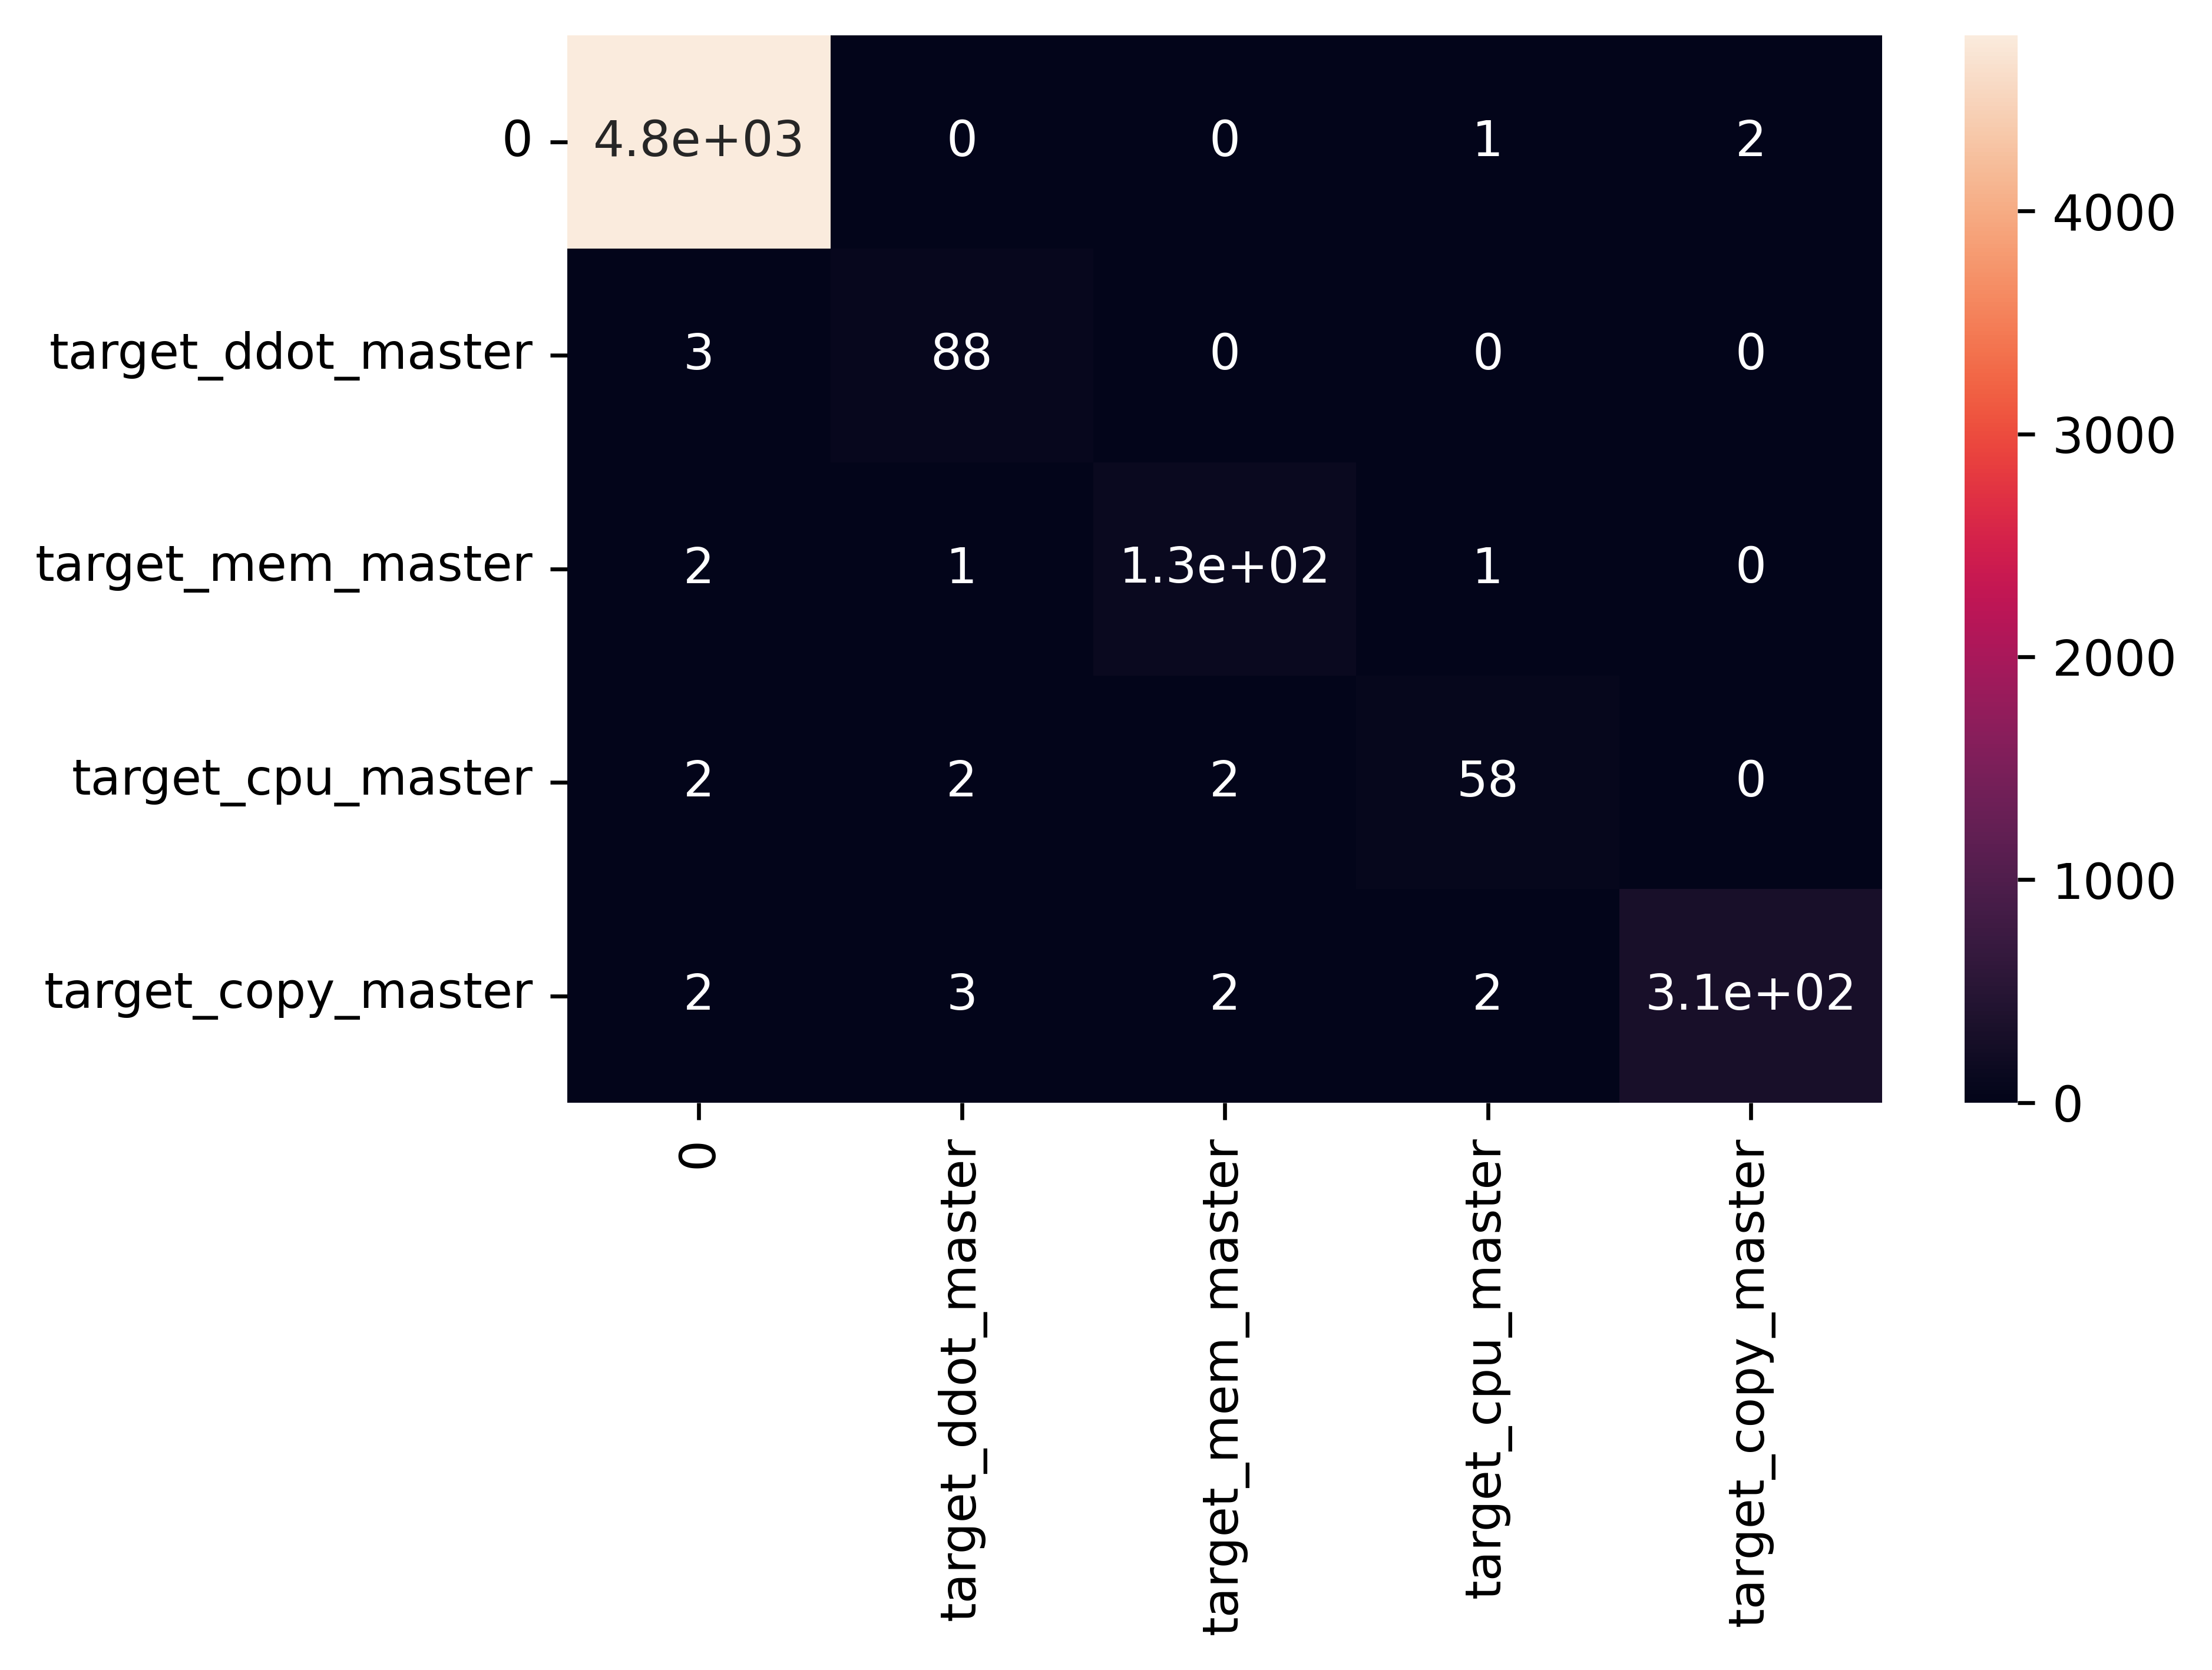

In [16]:
print("Confusion matrix")
cf_matrix = confusion_matrix(y, y_pred)
plt.figure(dpi=600)
sns_cf = sns.heatmap(cf_matrix, annot=True, yticklabels=list(definitions), xticklabels=list(definitions))
cf_fig = "{}_cf.png".format(prefix)
sns_cf.figure.savefig(os.path.join(model_dir, cf_fig), format='pdf',
           bbox_inches='tight', pad_inches=0)


# DNN history export
df_history = pd.DataFrame(cv.best_estimator_.model.history.history)
history_name = "{}_history.csv".format(prefix)
df_history.to_csv(os.path.join(model_dir, history_name), index=False)
df_history
# Extract Feature importance
# feat_importances = pd.Series(cv.best_estimator_.feature_importances_, index=list(data.drop('target', axis=1).columns))
# featureimp_name = "{}_hpo_best_featureimp.csv".format(prefix)
# feat_importances.to_csv(os.path.join(model_dir, featureimp_name), index=True)
# # print(feat_importances.head(10))
# sorted_feature = feat_importances.sort_values(ascending=True)
# # Plot the feature importances of the forest
# # plt.figure()
# plt.figure(figsize=(10,20), dpi=600)
# plt.title("Feature importances")
# plt.barh(range(X.shape[1]), sorted_feature,
#        color="r", align="center", )
# # If you want to define your own labels,
# # change indices to a list of labels on the following line.
# plt.yticks(range(X.shape[1]), sorted_feature.index)
# plt.ylim([-1, X.shape[1]])
# plt.show()


In [26]:
# Export DNN topology
# !{sys.executable} -m pip install pydotplus
!conda install -c anaconda graphviz

print("Saving topology")
topology_name = "{}_topology.png".format(prefix)
plot_model(cv.best_estimator_.model, to_file=os.path.join(model_dir, topology_name), show_shapes=True)

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: \ 
Found conflicts! Looking for incompatible packages.
This can take several minutes.  Press CTRL-C to abort.
Examining numexpr:  17%|████                   | 25/143 [00:11<00:26,  4.38it/| ^C
failed                                                                        

CondaError: KeyboardInterrupt

Saving topology
('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


Scoring on holdout or other dataset

In [75]:
#Creating the dependent variable class
# factor_h = pd.factorize(df_clean['target'])
# df_clean.target = factor_h[0]
# definitions_h = factor_h[1]

In [85]:
# print("Splitting dataset into data and ground truth ...")
# X_h = df_clean.drop('target', axis=1)
# y_h = df_clean['target']

# Scale
# X_h

In [82]:
# X_h = scaler.transform(X_h)


In [83]:
# y_pred_h = cv.best_estimator_.predict(X_h)
#
# custom_scoring_reporting(y_pred_h, y_h, definitions, prefix="rf_holdout")

In [84]:
# y_pred = cv.best_estimator_.predict(X)
# custom_scoring_reporting(y_pred, y, definitions, prefix)

# jaccard_score(y_h, y_pred_h, average='micro')
# y_pred_h